In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.preprocessing import OneHotEncoder
import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
# Read the processed data
df_train = pd.read_csv('./trian_mod_final.csv') 
df_test = pd.read_csv('./test_mod_final.csv') 

df_train

,case_month,lat,long,age,sex2,icu_yn,hosp_yn,cpsi,underlying_conditions_yn,race,ethnicity,death_yn
0,2020-01,43.241700,-75.4359,34,Missing,False,False,0.0,False,Omitted,Omitted,0.0
1,2020-01,35.759573,-79.0193,34,Missing,False,False,41.0,True,Omitted,Omitted,0.0
2,2020-01,35.759573,-79.0193,34,Missing,False,False,44.0,False,Omitted,Omitted,0.0
3,2020-01,35.759573,-79.0193,34,Missing,False,False,52.0,False,Omitted,Omitted,0.0
4,2020-01,35.759573,-79.0193,34,Missing,False,False,53.0,False,Omitted,Omitted,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
13394398,2021-09,34.991500,-78.3714,34,Female,False,False,0.0,False,Omitted,Omitted,0.0
13394399,2021-09,39.438600,-84.5756,9,Female,False,False,0.0,False,White,Non-Hispanic/Latino,0.0
13394400,2021-09,26.152300,-80.4871,80,Male,False,False,200.0,False,White,Non-Hispanic/Latino,0.0
13394401,2021-09,41.317200,-80.7611,9,Male,False,False,0.0,False,White,Unknown,0.0


In [3]:
# Encode sex2 variable as one-hot. 
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
enc.fit(df_train[['sex2']])
sex2_train = enc.transform(df_train[['sex2']])
sex2_test = enc.transform(df_test[['sex2']])

# Encode race variable as one-hot. 
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
enc.fit(df_train[['race']])
race_train = enc.transform(df_train[['race']])
race_test = enc.transform(df_test[['race']])

# Encode ethnicity variable as one-hot. 
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
enc.fit(df_train[['ethnicity']])
ethnicity_train = enc.transform(df_train[['ethnicity']])
ethnicity_test = enc.transform(df_test[['ethnicity']])



In [4]:
#store labels
Y = df_train['death_yn']

#extract features from df
X = df_train.loc[:,['lat','long','icu_yn','age','hosp_yn','cpsi','underlying_conditions_yn']].to_numpy()
X_final = df_test.loc[:,['lat','long','icu_yn','age','hosp_yn','cpsi','underlying_conditions_yn']].to_numpy()

In [5]:
#combine data and one hot encodings
X =  np.concatenate([X, sex2_train, race_train,ethnicity_train], axis=1)
X_final = np.concatenate([X_final, sex2_test, race_test,ethnicity_test], axis=1)

In [6]:
#Split data into test and training sample 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)


In [7]:
# Use AdaBoostClassifier with DecisionTreeClassifier as the base model
DTC = DecisionTreeClassifier()
model = AdaBoostClassifier(base_estimator = DTC)

In [8]:
# Use GridSearchCV to optimize hyper parameters
# The parameter search can be increased as desired, I do a pretty small search
param_grid = {"base_estimator__criterion" : ["gini"],
              "base_estimator__splitter" : ["best"],
              "base_estimator__max_depth": [2,3],
              "n_estimators": [50,75]
             }


grid_search_ABC = GridSearchCV(model, param_grid=param_grid, scoring = 'roc_auc', n_jobs=-1,cv=3)

grid_search_ABC.fit(X_train, Y_train)

/home/majd/.conda/envs/pytorch_env/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/majd/.conda/envs/pytorch_env/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/majd/.conda/envs/pytorch_env/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/majd/.conda/envs/pytorch_env/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/majd/.conda/envs/pytorch_env/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `e

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=-1,
             param_grid={'base_estimator__criterion': ['gini'],
                         'base_estimator__max_depth': [2, 3],
                         'base_estimator__splitter': ['best'],
                         'n_estimators': [50, 75]},
             scoring='roc_auc')

In [9]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_search_ABC.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_search_ABC.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search_ABC.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   n_estimators=75)

 The best score across ALL searched params:
 0.9859476062338987

 The best parameters across ALL searched params:
 {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 3, 'base_estimator__splitter': 'best', 'n_estimators': 75}


Test model accuracy: 0.9849!
Test AUROC: 0.9861


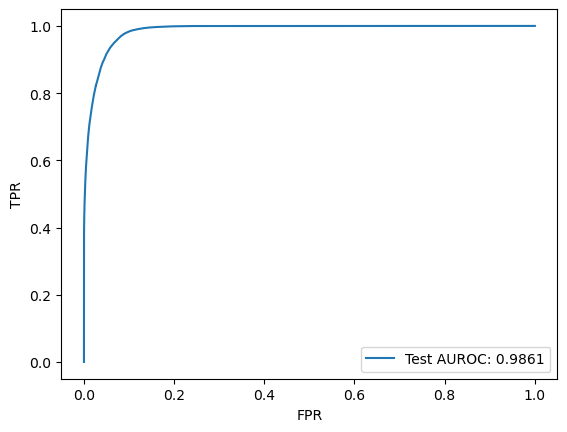

In [10]:
# Use the optimized model to evaluate performance on the held out validation set.
accuracy_test = np.mean(grid_search_ABC.best_estimator_.predict(X_test) == Y_test)
print(f'Test model accuracy: {accuracy_test:0.4f}!')

Yhat_test = grid_search_ABC.best_estimator_.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y_test, Yhat_test, pos_label=1)
auc_test = sklearn.metrics.auc(fpr, tpr)
print(f'Test AUROC: {auc_test:0.4f}')

plt.plot(fpr, tpr, label=f'Test AUROC: {auc_test:0.4f}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [11]:
#Now, re-train the best model with the full data set (train + validation sets )
grid_search_ABC.best_estimator_.fit(X,Y)

/home/majd/.conda/envs/pytorch_env/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   n_estimators=75)

In [12]:
# Make predictions on final test data
ypred = grid_search_ABC.best_estimator_.predict_proba(X_final)[:,1]


In [13]:
# Create kaggle submission file
submission = pd.DataFrame(ypred, columns=['prediction']) # Create new dataframe.
submission['Id'] = submission.index  # Kaggle expects two columns: Id, prediction.
submission.to_csv('AdaBoost_opt_submission.csv', index=False)